In [1]:
import pandas as pd
import glob, os

weather = pd.DataFrame()
li = []

all_files = glob.glob(os.path.join("data", "*.csv")) 

for file in all_files:
    df = pd.read_csv(
        file,
        engine="python", 
        index_col="ob_time", 
        skiprows=280, 
        skipfooter=1
    )
    li.append(df)

weather = pd.concat(li)

ValueError: No objects to concatenate

In [162]:
null_pct = weather.apply(pd.isnull).sum() / weather.shape[0]
valid_cols = weather.columns[null_pct < .05]

valid_cols = valid_cols.drop([col for col in valid_cols if "_q" in col])
valid_cols = valid_cols.drop([col for col in valid_cols if "_j" in col])

valid_cols = valid_cols.drop([
    "rec_st_ind", "id_type", "met_domain_name", "version_num", "src_id", "meto_stmp_time", "wind_speed_unit_id", "src_opr_type"
], errors="ignore")

weather = weather[valid_cols].copy()

In [163]:
weather = weather.ffill()
weather.fillna(0.0, inplace=True)

In [164]:
weather.index = pd.to_datetime(weather.index)

In [165]:
weather["target"] = weather.shift(-1)["air_temperature"]
weather = weather.ffill()

In [166]:
from sklearn.linear_model import Ridge

rr = Ridge(alpha=.1)

In [167]:
predictors = weather.columns[~weather.columns.isin(["id", "target"])]

In [168]:
def backtest(weather, model, predictors, start=3650, step=90):
    all_preds = []
    for i in range(start, weather.shape[0], step):
        train = weather.iloc[:i,:]
        test = weather.iloc[i:(i+step),:]

        model.fit(train[predictors], train["target"])

        preds = model.predict(test[predictors])

        preds = pd.Series(preds, index=test.index)
        combined = pd.concat([test["target"], preds], axis=1)

        combined.columns = ["actual", "prediction"]

        combined["diff"] = (combined["prediction"] - combined["actual"]).abs()

        all_preds.append(combined)
    return pd.concat(all_preds)

In [169]:
predictions = backtest(weather, rr, predictors)

In [170]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(predictions["actual"], predictions["prediction"])

0.843883503774444

<Axes: xlabel='ob_time'>

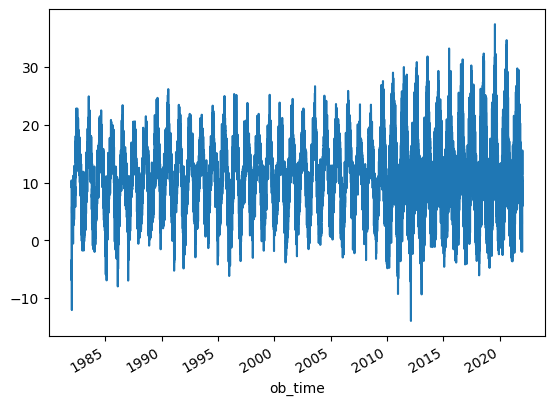

In [173]:
predictions["prediction"].plot()

<Axes: xlabel='ob_time'>

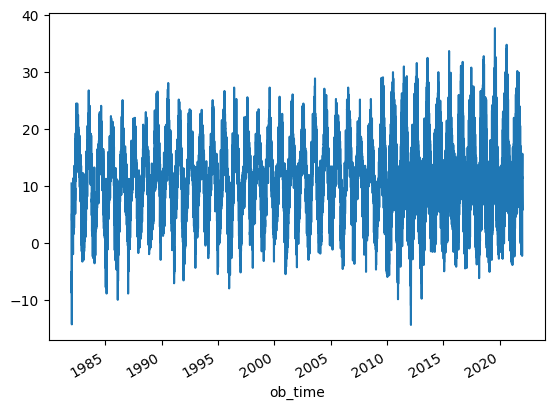

In [174]:
predictions["actual"].plot()

<Axes: xlabel='ob_time'>

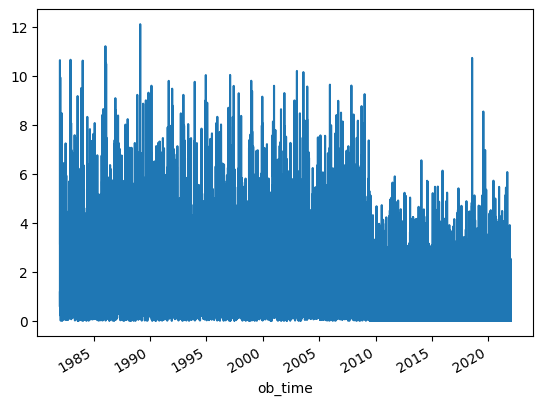

In [175]:
predictions["diff"].plot()